In [53]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import seaborn as sns
from sklearn.datasets import make_moons
from sklearn.metrics import accuracy_score, f1_score
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
import time
import numpy as np
import pandas as pd

In [54]:
def moveTo(obj, device):
    """
    obj: the python object ot move to a device, or to move its contents to a device
    device: the compute device to move objects to
    """
    if isinstance(obj, list):
        return [moveTo(o, device) for o in obj]
    elif isinstance(obj, tuple):
        return tuple(moveTo(o, device) for o in obj)
    elif isinstance(obj, set):
        return set(moveTo(o, device) for o in obj)
    elif isinstance(obj, dict):
        to_ret = dict()
        for k, v in obj.items():
            to_ret[moveTo(k, device)] = moveTo(v, device)
        return to_ret
    elif hasattr(obj, "to"):
        return obj.to(device)
    else:
        return obj

In [55]:
def run_epoch(model, optimizer, data_loader, loss_func, device, results, score_funcs, prefix=""):
    # init empty variables
    running_loss = []
    y_true = []
    y_pred = []
    start = time.time()
    # loop over the batchs
    for inputs, labels in data_loader:
        # move x, y to correct device
        inputs = moveTo(inputs, device=device)
        labels = moveTo(labels, device=device)

        # estimate
        y_hat = model(inputs)

        # compute loss, backpropagate and apply gradients if needed
        loss = loss_func(y_hat, labels)
        if model.training:
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        # store the results
        running_loss.append(loss.item())
        if score_funcs is not None and len(score_funcs) > 1 and isinstance(labels, torch.Tensor):
            labels = labels.detach().cpu().numpy()
            y_hat = y_hat.detach().cpu().numpy()
            y_true.extend(labels.tolist())
            y_pred.extend(y_hat.tolist())
        
    end = time.time()

    # clean results to compute metrics under sklearn standards
    y_pred = np.asarray(y_pred)
    if len(y_pred.shape) == 2 and y_pred.shape[1] > 1:
        y_pred = np.argmax(y_pred, axis=1)
    
    results[prefix + ' loss'].append(np.mean(running_loss))
    if score_funcs is not None:
        for name, score_func in score_funcs.items():
            try:
                results[prefix + " " + name].append( score_func(y_true, y_pred) )
            except:
                results[prefix + " " + name].append(float("NaN"))
    return end-start #time spent on epoc

def train_simple_network(
        model, loss_func, train_loader, test_loader=None, score_funcs=None, device='cpu', epochs=50, checkpoint_file=None
    ):
    # init tracking metrics
    to_track = ["epoch", "total time", "train loss"]
    if test_loader is not None:
        to_track.append("test loss")
    if score_funcs is not None:
        for eval_score in score_funcs:
            to_track.append("train " + eval_score )
            if test_loader is not None:
                to_track.append("test " + eval_score )
    total_train_time = 0
    results = {}
    for item in to_track:
        results[item] = []

    # initialize optimizer
    optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

    # start training loop
    model.to(device)
    for epoch in tqdm(range(epochs), desc="Epoch"):
        # pass the model throught a epoch
        model = model.train()
        total_train_time += run_epoch(
            model, 
            optimizer, 
            train_loader, 
            loss_func, 
            device, 
            results, 
            score_funcs, 
            prefix="train", 
        )
    
        # grab more results from the last epoch
        results["total time"].append( total_train_time )
        results["epoch"].append( epoch )

        # test the model in validation
        if test_loader is not None:
            model = model.eval()
            with torch.no_grad():
                run_epoch(model, optimizer, test_loader, loss_func, device, results, score_funcs, prefix="test")

    # save the model checkpoint
    if checkpoint_file is not None:
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'results' : results
            }, checkpoint_file)

    return pd.DataFrame.from_dict(results)

### 1

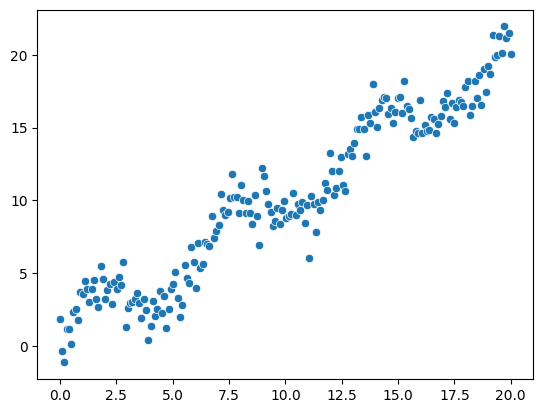

In [56]:
# datos simulados para un problema de regresion
X = np.linspace(0, 20 , num=200).reshape(-1, 1)
y = X + np.sin(X)*2 + np.random.normal(size=X.shape).reshape(-1, 1)
sns.scatterplot(x=X[:,0], y=y[:, 0])

class Simple1DRegressionDataset(Dataset):
    def __init__(self, X, y):
        super(Simple1DRegressionDataset, self).__init__()
        self.X = X
        self.y = y

    def __getitem__(self, index):
        return (
            torch.tensor(self.X[index, :], dtype=torch.float32),
            torch.tensor(self.y[index], dtype=torch.float32)    
        )
    
    def __len__(self):
        return self.X.shape[0]

training_loader = DataLoader(Simple1DRegressionDataset(X, y), shuffle=True)

In [57]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

In [58]:
class StandardScale1DRegressionDataset(Dataset):
    def __init__(self, X, y):
        super(StandardScale1DRegressionDataset, self).__init__()
        self.X = X
        self.y = self.standard_scale(y)
    
    @staticmethod  # probably not a staticmethod in real life 
    def standard_scale(x):
        scaler = StandardScaler()
        scaler.fit(x)
        return scaler.transform(x)

    def __getitem__(self, index):
        return (
            torch.tensor(self.X[index, :], dtype=torch.float32),
            torch.tensor(self.y[index], dtype=torch.float32)    
        )
    
    def __len__(self):
        return self.X.shape[0]

standard_training_loader = DataLoader(StandardScale1DRegressionDataset(X, y), shuffle=True)

In [59]:
# without scaling
in_features = 1
out_features = 1
model = nn.Linear(in_features, out_features)
loss_func = nn.MSELoss()

result = train_simple_network(
    model,
    loss_func,
    training_loader,
)

Epoch:   0%|          | 0/50 [00:00<?, ?it/s]